Exploratory Data Analysis

In [ ]:
import json
import sys
import argparse
import cv2

import PIL
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from google.colab import drive

drive.mount('/content/gdrive')
df = pd.read_csv('gdrive/My Drive/age_gender.csv')

Mounted at /content/gdrive


In [ ]:
def draw_face(row_num, df_row):
  df_row = [int(i) for i in df_row[row_num].split()]
  pixels = []
  for i in range(0, 48):
    temp = []
    for j in range(0, 48):
      temp.append(df_row[i * 48 + j])
    pixels.append(temp)
  array = np.array(pixels, dtype=np.uint8)
  return Image.fromarray(array)

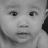

In [ ]:
df_pixels = df['pixels']
face = draw_face(0, df_pixels)
face

In [ ]:
df = df.drop('img_name', axis = 1)
visual_df = df.drop('pixels', axis = 1)

In [ ]:
images = []

for i in range(len(df)): # len(df)
  images.append(draw_face(i, df['pixels']))

df["image"] = images
df.head()


,age,ethnicity,gender,img_name,pixels,images,image
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...,<PIL.Image.Image image mode=L size=48x48 at 0x...,<PIL.Image.Image image mode=L size=48x48 at 0x...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...,<PIL.Image.Image image mode=L size=48x48 at 0x...,<PIL.Image.Image image mode=L size=48x48 at 0x...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...,<PIL.Image.Image image mode=L size=48x48 at 0x...,<PIL.Image.Image image mode=L size=48x48 at 0x...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...,<PIL.Image.Image image mode=L size=48x48 at 0x...,<PIL.Image.Image image mode=L size=48x48 at 0x...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...,<PIL.Image.Image image mode=L size=48x48 at 0x...,<PIL.Image.Image image mode=L size=48x48 at 0x...


In [ ]:
import cv2
import os
import numpy as np
from random import shuffle

TRAIN = df[["ethnicity", "image"]][0:11852]
TEST = df[["ethnicity", "image"]][11852:23705]
IMG_SIZE = 48
LR = 1e-3

MODEL_NAME = 'ethnicity_model'

def label_img(row):
  return [row["ethnicity"], 0]

def create_train_data():
  training_data = []

  for i in range(len(TRAIN)):
    label = label_img(TRAIN.iloc[i])
    training_data.append([np.array(TRAIN.iloc[i]["image"]), np.array(label)])
    shuffle(training_data)

  np.save('train_data.npy', training_data)
  return training_data

def process_test_data():
  test_data = []

  for i in range(len(TEST)):
    label = label_img(TEST.iloc[i])
    test_data.append([np.array(TEST.iloc[i]["image"]), np.array(label)])
    shuffle(test_data)

  np.save('test_data.npy', test_data)
  return test_data
  
train_data = create_train_data()
test_data = process_test_data()

In [ ]:
import tensorflow as tf

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape = [None, IMG_SIZE, IMG_SIZE, 1], name ='input')

convnet = conv_2d(convnet, 32, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation ='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation ='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation ='softmax')
convnet = regression(convnet, optimizer ='adam', learning_rate = LR, loss ='categorical_crossentropy', name ='targets')

model = tflearn.DNN(convnet, tensorboard_dir ='log')


In [ ]:
X = np.array([i[0] for i in train_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train_data]
test_x = np.array([i[0] for i in test_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test_data]

# model.fit({'input': X}, {'targets': Y}, n_epoch = 5, 
#   validation_set =({'input': test_x}, {'targets': test_y}), 
#   snapshot_step = 500, show_metric = True, run_id = MODEL_NAME)
# model.save(MODEL_NAME)

In [ ]:
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
import numpy as np

from keras.models import load_model

model = load_model('ethnicity_model.h5')

def num_to_race(num):
  if num == 0:
    return "WHITE"
  elif num == 1: 
    return "BLACK"
  elif num == 2:
    return "ASIAN"
  elif num == 3: 
    return "INDIAN"
  elif num == 4: 
    return "HISPANIC"

In [ ]:
img_num = 22428
img = np.array(draw_face(img_num, df['pixels']))
img = img / 255.0
img = img.reshape(-1,48,48,1)
label = model.predict(img)
label

array([[0.13133757, 0.17400663, 0.54367626, 0.06759436, 0.08338516]],
      dtype=float32)

In [ ]:
prediction = np.argmax(label)
print("Predicted Ethnicity: ", num_to_race(prediction))
print("Actual Ethnicity: ", num_to_race(df["ethnicity"].iloc[img_num]))

Predicted Ethnicity:  ASIAN
Actual Ethnicity:  ASIAN


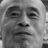

In [ ]:
draw_face(img_num, df["pixels"])

[Text(0.5, 0, 'Age'), Text(0.5, 1.0, 'Frequency of Ages')]

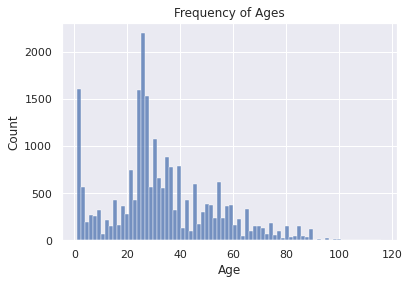

In [ ]:
sns.histplot(data = visual_df, x = "age").set(title = "Frequency of Ages", xlabel = "Age")

Text(0.5, 1.0, 'Distribution of Ethnicities')

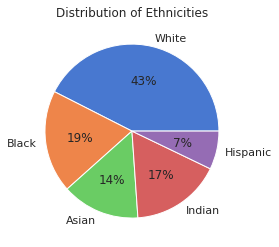

In [ ]:
colors = sns.color_palette("muted")
freq = [0, 0, 0, 0, 0]
labels = ["White", "Black", "Asian", "Indian", "Hispanic"]
for i in df['ethnicity']:
  freq[i] += 1
plt.pie(freq, labels = labels, colors = colors, autopct='%.0f%%')
plt.title("Distribution of Ethnicities")

Text(0.5, 1.0, 'Distribution of Genders')

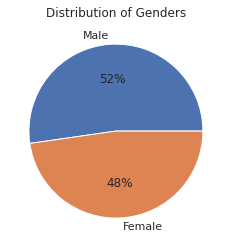

In [ ]:
colors2 = sns.color_palette("deep")
freq2 = [0, 0]
labels2 = ["Male", "Female"]
for i in df['gender']:
  freq2[i] += 1
plt.pie(freq2, labels = labels2, colors = colors2, autopct='%.0f%%')
plt.title("Distribution of Genders")

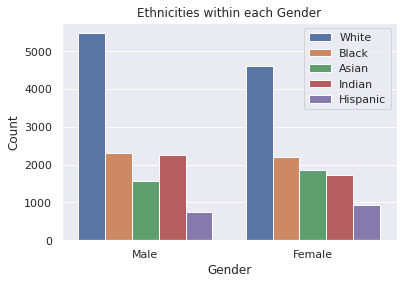

In [ ]:
temp0 = visual_df.copy()
temp0['gender'] = temp0['gender'].replace([0],'Male')
temp0['gender'] = temp0['gender'].replace([1],'Female')
sns.countplot(x = temp0['gender'], hue = temp0["ethnicity"]).set(title = "Ethnicities within each Gender", xlabel = "Gender", ylabel = "Count")
plt.legend(labels = ["White", "Black", "Asian", "Indian", "Hispanic"])

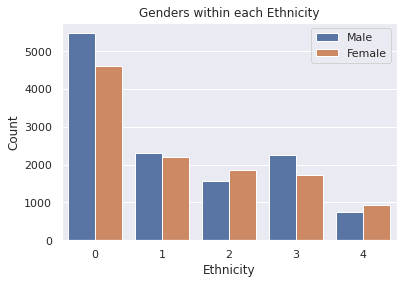

In [ ]:
temp = visual_df.copy()
temp['ethnicity'] = temp['ethnicity'].replace([0],'White')
temp['ethnicity'] = temp['ethnicity'].replace([1],'Black')
temp['ethnicity'] = temp['ethnicity'].replace([2],'Asian')
temp['ethnicity'] = temp['ethnicity'].replace([3],'Indian')
temp['ethnicity'] = temp['ethnicity'].replace([4],'Hispanic')
sns.countplot(x = visual_df['ethnicity'], hue = visual_df["gender"]).set(title = "Genders within each Ethnicity", xlabel = "Ethnicity", ylabel = "Count")
plt.legend(labels = ["Male", "Female"])

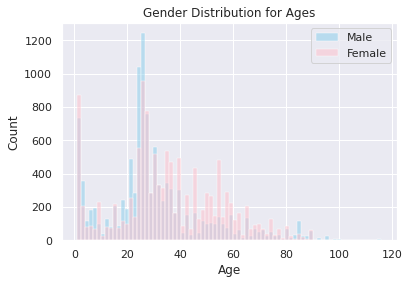

In [ ]:
sns.histplot(data = visual_df, x = "age", hue = "gender", palette = ["pink", "skyblue"]).set(title = "Gender Distribution for Ages", xlabel = "Age")
plt.legend(labels = ["Male", "Female"])

[Text(0.5, 0, 'Age'), Text(0.5, 1.0, 'Frequency of Ages for Hispanic')]

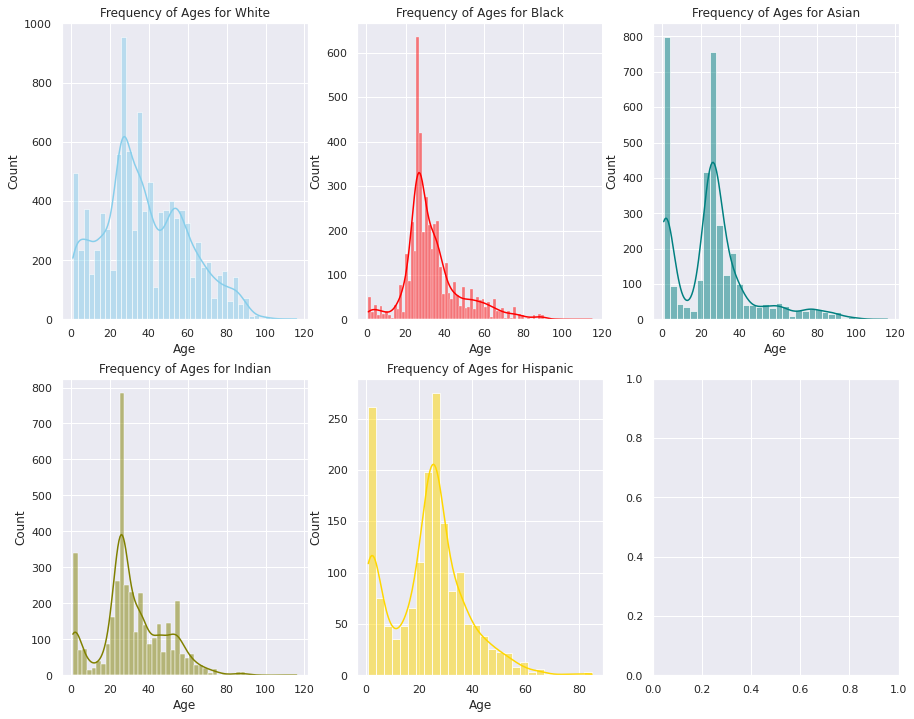

In [ ]:
fig, axs = plt.subplots(2, 3, figsize = (15, 12))
sns.histplot(data = visual_df[visual_df['ethnicity'] == 0], x = "age", kde = True, color = "skyblue", ax = axs[0, 0]).set(title = "Frequency of Ages for White", xlabel = "Age")
sns.histplot(data = visual_df[visual_df['ethnicity'] == 1], x = "age", kde = True, color = "red", ax = axs[0, 1]).set(title = "Frequency of Ages for Black", xlabel = "Age")
sns.histplot(data = visual_df[visual_df['ethnicity'] == 2], x = "age", kde = True, color = "teal", ax = axs[0, 2]).set(title = "Frequency of Ages for Asian", xlabel = "Age")
sns.histplot(data = visual_df[visual_df['ethnicity'] == 3], x = "age", kde = True, color = "olive", ax = axs[1, 0]).set(title = "Frequency of Ages for Indian", xlabel = "Age")
sns.histplot(data = visual_df[visual_df['ethnicity'] == 4], x = "age", kde = True, color = "gold", ax = axs[1, 1]).set(title = "Frequency of Ages for Hispanic", xlabel = "Age")